# Consistent Monthly Gainers

In Michael Kramer's "Reading the Markets" trading chatroom I asked the following question:
> I have a question for everyone: Imagine you took all stocks that are currently listed in the US and that have at least 10 years of trading history and you looked at their MONTHLY price histories, and ordered them by how often they had a positive return in a given month. So, instead of looking at average monthly appreciation, or compound appreciation, you'd be looking for consistency of appreciation. My question: Which stocks do you think would have done best? And how often might the top performer have been up? 10 years = 120 months, so maybe 90 months of positive returns? 100? I don't know the answers but I am curious.

Sadly, nobody responded. :(

Still, I was curious. Why? An explanation is in order:

Yes, in the end, it all comes down to compound annual growth rates (cagr). A stock that treads water or even loses value for 2 out of every 3 months can still have a superior appreciation, if in the remaining month it performs spectacularly. So, why should anyone care about the frequency of positive returns? Isn't that just the wrong thing to look at? I don't think so:

There's a truism about the human psyche, which holds that the pain we feel from suffering is always more intense than the joy we derive from our victories. So, rollercoaster stocks may bring supreme *financial* gains, but that gain comes at the cost of great *emotional* loss. The practical consequence is that there's always a temptation to sell such volatile winners too soon, or, at the very least, to hold significant cash or other hedges to offset the pain these stocks intermittently inflict.

The other extreme would be a stock that goes up very slightly every month. If an investor takes confidence from the consistency of such a stock, (s)he might reduce cash reserves to allocate more capital to it, thus compensating for the smaller percentage returns experienced by such a stock.

So, I had to find out: Which stocks are consistent monthly winners? Are they different from others in some way?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

`STATSFILE` (below) is a CSV file containing one row for US-listed equities with at least 10 years of history, excluding SPACs, units, ETFs, over-the-counter issues, and secondary stock classes. The data is originally assembled using AlphaVantage, the SEC, and MergentOnline. For each of these equities I obtained monthly stock price information from Tiingo and calculated the number of positive monthly returns between 04/2011 and 03/2021, inclusively. There are 2,828 stocks in the dataset.

`CLASSIFICATIONFILE` provides sector and industry assignments for each stock in `STATSFILE`.

In [2]:
STATSFILE = './stats.csv'
CLASSIFICATIONFILE = './classification.csv'
stats = pd.read_csv(STATSFILE, index_col="ticker")
classification = pd.read_csv(CLASSIFICATIONFILE, index_col='symbol')
df = classification.merge(stats, how='left', left_index=True, right_index=True).sort_index()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2828 entries, A to ZYXI
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              2828 non-null   object
 1   sector            2828 non-null   object
 2   industry          2828 non-null   object
 3   positive returns  2828 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 110.5+ KB


In [4]:
df.head(10) # The table below shows the first 10 records of the dataset. Note that AAPL has
            # fewer positive monthly returns than one might expect from such a stellar performer.

,name,sector,industry,positive returns
symbol,,,,
A,Agilent Technologies Inc,HEALTHCARE,HCAREMISC,68
AACG,ATA Creativity Global,NONCYCLICAL,HOUSESVCE,52
AAIC,Arlington Asset Investment Corp,FINANCIAL,REIT,62
AAL,American Airlines Group Inc,INDUSTRIAL,PASSENGERTRANS,66
AAME,Atlantic American Corp,FINANCIAL,INSURANCE,54
AAON,AAON Inc,INDUSTRIAL,MACHINE,74
AAP,Advance Auto Parts Inc.,CYCLICALS,AUTORETAIL,65
AAPL,Apple Inc,TECH,COMMEQUIP,70
AAT,American Assets Trust Inc,FINANCIAL,REIT,71


Let's create a couple of data series to hold the sector and industry frequencies in the overall population.

In [5]:
sectorcount = df['sector'].value_counts(sort=True)
industrycount = df['industry'].value_counts(sort=False).sort_index()


In [6]:
sectorcount

FINANCIAL       724
HEALTHCARE      390
TECH            326
INDUSTRIAL      318
MATERIALS       238
CYCLICALS       180
NONCYCLICAL     171
ENERGY          145
BIZSVCE         106
CONSUMERSVCE    100
UTIL             71
TELECOM          59
Name: sector, dtype: int64

In [7]:
industrycount.head()

AERODEF            41
AGRICULTURE        14
APPARELPRODUCTS    31
APPARELRETAIL      22
APPLIANCESFURN      8
Name: industry, dtype: int64

And one more series, `freq`, to contain the distribution of stocks across a given number of positive monthly returns. So, the series index is the number of months (out of a max of 120) with positive returns, while the value of the series is the number of stocks achieving exactly that number. If no stocks achieved a given level, then that index level is missing in `freq`.

In [8]:
freq = df['positive returns'].value_counts(sort=False).sort_index()
freq.tail(10) # Last 10 records of freq series

74    81
75    67
76    44
77    31
78    19
79    10
80     9
81    11
82     6
83     4
Name: positive returns, dtype: int64

Time to plot `freq`:

[Text(0.5, 0, 'positive return months'),
 Text(0, 0.5, 'number of stocks'),
 Text(0.5, 1.0, 'Number of Months with Positive Returns in the Last Ten Years,\nFrequency Distribution Across US-Listed Stocks (n=2828)')]

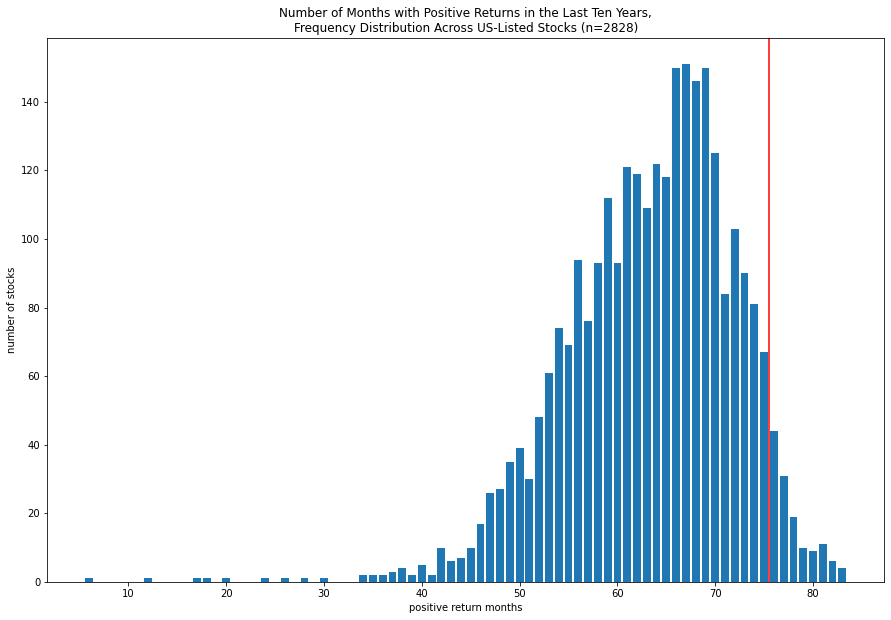

In [9]:
fig, ax = plt.subplots(figsize=[15,10])
ax.bar(freq.index, freq)
ax.axvline(x = 75.5, color = 'r', label='cutoff')  
ax.set(xlabel='positive return months',
       ylabel='number of stocks',
       title=f'Number of Months with Positive Returns in the Last Ten Years,\nFrequency Distribution Across US-Listed Stocks (n={len(df)})')

In [10]:
returns = df['positive returns']
retmean = returns.mean()
sigma = returns.std()
twoSigma = retmean + 2*sigma
print(f'Average number of positive months: {retmean:.2f}\nStandard Deviation: {sigma:.2f}\n2 Sigma level: {twoSigma:.2f}')

Average number of positive months: 63.37
Standard Deviation: 8.53
2 Sigma level: 80.43


I am looking for a cutoff level that would separate the top performers from the rest of the group. The data does not look normally distributed, as the left tail appears a lot longer than the right. A bunch of normality tests I ran seemed inconclusive (see the end). So, instead of using standard deviations to characterize the top echelon, I decided to focus on the top 5%, which conveniently also conincides with the number of stocks that sit above the median plus interquartile range `(64 + (69-58)=75` (see below).

In [11]:
returns.quantile([.01, .025, 0.05, .1, .25, .5, .75, .9, 0.95, 0.975, 0.99])

0.010    40.27
0.025    46.00
0.050    49.00
0.100    52.00
0.250    58.00
0.500    64.00
0.750    69.00
0.900    73.00
0.950    75.00
0.975    77.00
0.990    80.00
Name: positive returns, dtype: float64

And drumroll...

Here, finally, are the winners:

In [12]:
topstocks = df[df['positive returns']> 75].sort_values(by='positive returns', ascending=False)
topstocks

,name,sector,industry,positive returns
symbol,,,,
SPGI,S&P Global Inc,TECH,INTERNET,83
MA,Mastercard Inc,FINANCIAL,FINSPECIAL,83
FAF,First American Financial Corp,FINANCIAL,INSURANCE,83
CTAS,Cintas Corp,BIZSVCE,BIZSUPPORT,83
V,Visa Inc,FINANCIAL,FINSPECIAL,82
...,...,...,...,...
SO,Southern Co (The),UTIL,ENERGYUTIL,76
DEI,Douglas Emmett Inc,FINANCIAL,REIT,76
STE,Steris Plc,HEALTHCARE,HCAREMISC,76


In [23]:
topstocks[topstocks['sector']=='HEALTHCARE'].sort_values(by='positive returns', ascending=False)

,name,sector,industry,positive returns
symbol,,,,
UNH,Unitedhealth Group Inc,HEALTHCARE,HCARESUPPORT,79
RMD,Resmed Inc,HEALTHCARE,MEDDEVICESOTHER,79
ALGN,Align Technology Inc,HEALTHCARE,MEDDEVICESOTHER,78
WST,West Pharmaceutical Services Inc.,HEALTHCARE,HCAREDIAGNOSTICS,78
ABT,Abbott Laboratories,HEALTHCARE,MEDDEVICESGEN,76
TMO,Thermo Fisher Scientific Inc,HEALTHCARE,MEDDEVICESGEN,76
JNJ,Johnson & Johnson,HEALTHCARE,BIOPHARMAOTHER,76
ICLR,Icon PLC,HEALTHCARE,HCAREOUTSOURCE,76
LLY,Eli Lilly and Co,HEALTHCARE,BIOPHARMAOTHER,76


In [14]:
faang = ['AAPL','GOOGL', 'FB', 'NFLX', 'AMZN'] # Where are all the FAANG stocks?
df.loc[df.index.isin(faang)]

,name,sector,industry,positive returns
symbol,,,,
AAPL,Apple Inc,TECH,COMMEQUIP,70
AMZN,Amazon.com Inc,NONCYCLICAL,GENMERCH,73
GOOGL,Alphabet Inc,TECH,INTERNET,75
NFLX,Netflix Inc,TECH,INTERNET,76


NFLX is the only of the FAANG stocks to make the cutoff. That might surprise some. Granted, FB was disqualified by its lack of 10-year trading history and the others get close to the top 5%. Given this group's massive outperformance over the past few years one might have expected them at the top of this list, as well.

Another slight disappointment was the number of positive months for even the greatest winners. We are looking back at 120 months of returns. And the median stock managed to have a positive return in just 64 of these 120 months. Only 1% of stocks managed to make their owners money in at least two out of every three months (80+ out of 120).

The only explanation I can think of for that last point is that market-wide sell-offs tend to swamp the idiosyncracies of stocks. That, in fact, may be an opportunity for the alert: If these top gainers really only drop during times of market distress, then money may be made by focusing investments on them, once the dust clears at the end of a significant sell-offf.

In [15]:
sectortops = topstocks['sector'].value_counts(sort=False)
sectortops

UTIL            16
TECH            17
TELECOM          3
INDUSTRIAL      15
FINANCIAL       40
MATERIALS        7
CONSUMERSVCE     4
NONCYCLICAL      3
CYCLICALS        7
BIZSVCE         12
HEALTHCARE      10
Name: sector, dtype: int64

In [22]:
sectorperf = sectortops/sectorcount
sectorperf.sort_values(ascending=False)

UTIL            0.225352
BIZSVCE         0.113208
FINANCIAL       0.055249
TECH            0.052147
TELECOM         0.050847
INDUSTRIAL      0.047170
CONSUMERSVCE    0.040000
CYCLICALS       0.038889
MATERIALS       0.029412
HEALTHCARE      0.025641
NONCYCLICAL     0.017544
ENERGY               NaN
Name: sector, dtype: float64

## Some tests of normality of the frequency data

The results end up being inclonclusive, so I didn't do any parametric analysis of the frequency data.

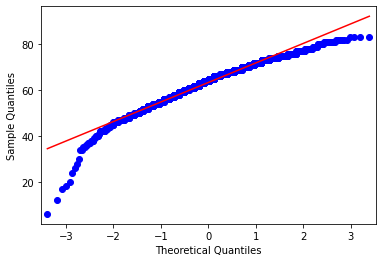

In [17]:
from statsmodels.graphics.gofplots import qqplot
qqplot(returns, line='s'); #the semicolon prevents duplication of the graph. See https://github.com/statsmodels/statsmodels/issues/1265#issuecomment-383336489

Looks like the left tail is too heavy and right one is light. Below are a few tests for normality.

In [18]:
from scipy.stats import shapiro, anderson, normaltest
shap, shap_p = shapiro(returns)
print(f"Shapiro test statistic: {shap}, p-value: {shap_p}\n")

Shapiro test statistic: 0.9677339792251587, p-value: 1.0397180814356146e-24



The Shapiro-Wilk test suggests normality is not violated, but I am skeptical. Below is an Anderson-Darling test.

In [19]:
andar = anderson(returns, dist='norm')
rstring = f'Anderson-Darling test statistic: {andar.statistic:.3f}\n'
for i in range(len(andar.critical_values)):
    rstring += f'Siglevel: {andar.significance_level[i]:2.0f},\tcritical value: {andar.critical_values[i]:.3f}\n'
print(rstring)

Anderson-Darling test statistic: 13.730
Siglevel: 15,	critical value: 0.575
Siglevel: 10,	critical value: 0.655
Siglevel:  5,	critical value: 0.786
Siglevel:  2,	critical value: 0.917
Siglevel:  1,	critical value: 1.090



Significant at every level. Suggests strongly that normality must be rejected.

In [20]:
dagpea, dagpea_p = normaltest(returns)
print(f"D\'Agostino-Pearson test statistic: {dagpea}, p-value: {dagpea_p}\n")

D'Agostino-Pearson test statistic: 368.51201821931966, p-value: 9.519891225621317e-81



D'Agostino-Pearson cannot reject the normal distribution null Hypothesis. What. Ever. So, there's just no clarity.